In [2]:
#import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Model configuration
img_width, img_height = 28, 28
batch_size = 150
no_epochs = 50
validation_split = 0.2
verbosity = 1
max_norm_value = 2.0
noise_factor = 0.55
number_of_visualizations = 6

In [4]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

# Reshape data based on channels first / channels last strategy.
# This is dependent on whether you use TF, Theano or CNTK as backend.
# Source: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
if K.image_data_format() == 'channels_first':
    input_train = input_train.reshape(input_train.shape[0], 1, img_width, img_height)
    input_test = input_test.reshape(input_test.shape[0], 1, img_width, img_height)
    input_shape = (1, img_width, img_height)
else:
    input_train = input_train.reshape(input_train.shape[0], img_width, img_height, 1)
    input_test = input_test.reshape(input_test.shape[0], img_width, img_height, 1)
    input_shape = (img_width, img_height, 1)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [5]:
# Add noise
pure = input_train
pure_test = input_test
noise = np.random.normal(0, 1, pure.shape)
noise_test = np.random.normal(0, 1, pure_test.shape)
noisy_input = pure + noise_factor * noise
noisy_input_test = pure_test + noise_factor * noise_test

In [6]:
# Create the model
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2DTranspose(32, kernel_size=(3,3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2DTranspose(64, kernel_size=(3,3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(1, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='sigmoid', padding='same'))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 26, 26, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         577       
Total params: 47,425
Trainable params: 47,425
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Compile and fit data
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(noisy_input, pure,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 48000 samples, validate on 12000 samples
Epoch 1/50


2023-03-01 11:34:26.832985: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3402225000 Hz
2023-03-01 11:34:26.833969: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559cac7f0de0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-03-01 11:34:26.834030: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


48000/48000 [==============================] - 476s 10ms/sample - loss: 0.1254 - val_loss: 0.1076
Epoch 2/50
48000/48000 [==============================] - 481s 10ms/sample - loss: 0.1048 - val_loss: 0.1034
Epoch 3/50
48000/48000 [==============================] - 411s 9ms/sample - loss: 0.1021 - val_loss: 0.1017
Epoch 4/50
48000/48000 [==============================] - 381s 8ms/sample - loss: 0.1007 - val_loss: 0.1012
Epoch 5/50
48000/48000 [==============================] - 394s 8ms/sample - loss: 0.0999 - val_loss: 0.1002
Epoch 6/50
48000/48000 [==============================] - 389s 8ms/sample - loss: 0.0993 - val_loss: 0.0996
Epoch 7/50
48000/48000 [==============================] - 384s 8ms/sample - loss: 0.0989 - val_loss: 0.0992
Epoch 8/50
48000/48000 [==============================] - 390s 8ms/sample - loss: 0.0984 - val_loss: 0.0989
Epoch 9/50
48000/48000 [==============================] - 300s 6ms/sample - loss: 0.0981 - val_loss: 0.0988
Epoch 10/50
48000/48000 [============

In [8]:
# Generate denoised images
samples = noisy_input_test[:number_of_visualizations]
targets = target_test[:number_of_visualizations]
denoised_images = model.predict(samples)

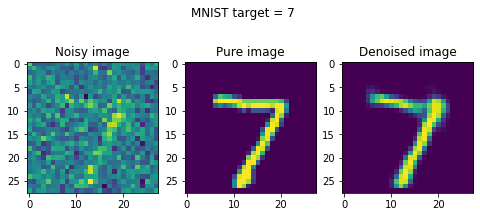

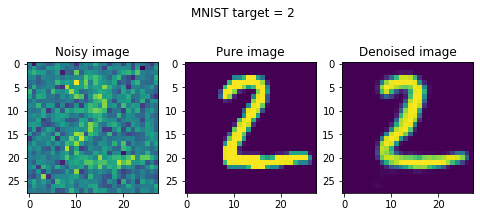

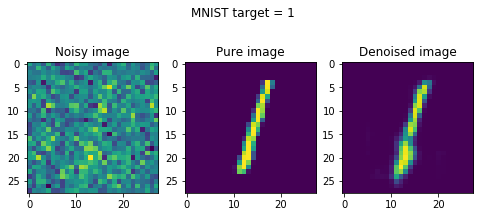

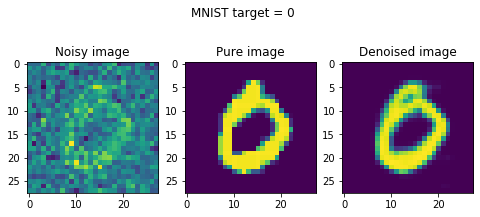

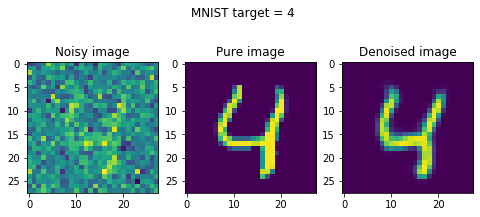

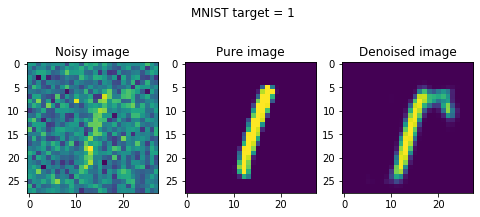

In [9]:
# Plot denoised images
for i in range(0, number_of_visualizations):
  # Get the sample and the reconstruction
  noisy_image = noisy_input_test[i][:, :, 0]
  pure_image  = pure_test[i][:, :, 0]
  denoised_image = denoised_images[i][:, :, 0]
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(8, 3.5)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image)
  axes[0].set_title('Noisy image')
  axes[1].imshow(pure_image)
  axes[1].set_title('Pure image')
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image')
  fig.suptitle(f'MNIST target = {input_class}')
  plt.show()